In [1]:
import requests
baby_url = 'http://0.0.0.0:5101' # URL to reach baby-phone

## Check version of the BABY server

In [2]:
r = requests.get(baby_url)
r.json() if r.ok else r.text

{'baby': 'v0.30.7'}

## Check which models are available

### Summary

In [3]:
r = requests.get(baby_url + '/models')
r.json() if r.ok else r.text

['ecoli-mothermachine-phase-EMCCD-100x-1z',
 'yeast-alcatras-brightfield-sCMOS-60x-5z',
 'yeast-alcatras-brightfield-EMCCD-60x-1z',
 'ecoli-mothermachine-phase-sCMOS-100x-1z',
 'yeast-alcatras-brightfield-sCMOS-60x-1z',
 'yeast-alcatras-brightfield-EMCCD-60x-5z',
 'yeast-alcatras-brightfield-sCMOS-60x-3z',
 'yeast-microcol-brightfield-sCMOS-100x-1z',
 'yeast-alcatras-brightfield-EMCCD-60x-3z',
 'example-modelset-yeast-alcatras-brightfield-EMCCD-60x-5z']

### Including additional meta data

In [4]:
r = requests.get(baby_url + '/models?meta=true')
r.json() if r.ok else r.text

{'ecoli-mothermachine-phase-EMCCD-100x-1z': {'species': 'ecoli',
  'device': 'mothermachine',
  'channel': 'phase',
  'camera': 'EMCCD',
  'optical_zoom': 100,
  'z_sections': 1,
  'pixel_size': 0.08},
 'yeast-alcatras-brightfield-sCMOS-60x-5z': {'species': 'yeast',
  'device': 'alcatras',
  'channel': 'brightfield',
  'camera': 'sCMOS',
  'optical_zoom': 60,
  'z_sections': 5,
  'pixel_size': 0.182},
 'yeast-alcatras-brightfield-EMCCD-60x-1z': {'species': 'yeast',
  'device': 'alcatras',
  'channel': 'brightfield',
  'camera': 'EMCCD',
  'optical_zoom': 60,
  'z_sections': 1,
  'pixel_size': 0.263},
 'ecoli-mothermachine-phase-sCMOS-100x-1z': {'species': 'ecoli',
  'device': 'mothermachine',
  'channel': 'phase',
  'camera': 'sCMOS',
  'optical_zoom': 100,
  'z_sections': 1,
  'pixel_size': 0.065},
 'yeast-alcatras-brightfield-sCMOS-60x-1z': {'species': 'yeast',
  'device': 'alcatras',
  'channel': 'brightfield',
  'camera': 'sCMOS',
  'optical_zoom': 60,
  'z_sections': 1,
  'pixel_s

## Start a new session

In [5]:
modelset = 'yeast-alcatras-brightfield-sCMOS-60x-1z'
r = requests.get(f'{baby_url}/session/{modelset}')
if not r.ok:
    raise Exception(f"{r.status_code}: {r.text}")
display(r.json())
session_id = r.json()['sessionid']

{'sessionid': '1af33e88-b53f-4bbd-ac11-bfad38e696e5'}

## List running sessions

In [6]:
r = requests.get(baby_url + '/sessions')
r.json() if r.ok else r.text

[{'id': '1af33e88-b53f-4bbd-ac11-bfad38e696e5',
  'model_name': 'yeast-alcatras-brightfield-sCMOS-60x-1z',
  'runner': 'pending'}]

## Send an image to the server

In [7]:
import numpy as np
rng = np.random.default_rng(42)

# Create suitable N x H x W x Z array
# dtype must be either uint8 or uint16
img = rng.integers(2**8, size=(2, 80, 120, 1), dtype='uint8')

# Initiate a multipart-encoded request
r = requests.post(f'{baby_url}/segment?sessionid={session_id}',
                  files=[
                      # The ordering of these parts must be fixed
                      ('dims', ('', str(list(img.shape)))),
                      ('bitdepth', ('', '8')),
                      ('img', ('', img.tobytes(order='F'))),
                      # Optionally specify additional parts that set
                      # any kwargs accepted by BabyCrawler.step (ordering
                      # is no longer fixed)
                      ('refine_outlines', ('', 'true')),
                  ])

r.json() if r.ok else r.text

{'status': 'processing 2 trap images'}

*NB: To run the following, `baby-phone` should have been started in debug mode (`baby-phone --debug-mode`) in a subfolder named `baby-phone-debugging`.*

In [8]:
from baby.io import load_tiled_image
img1, info1 = load_tiled_image("baby-phone-debugging/baby_phone_debugging_image_received_001.png")
# Check that the image received by the server is identical to the one sent
assert np.allclose(img1, img[0])
# metadata associated with the image (i.e., info1) includes the additional keyword arguments
img1.shape, img1.dtype, info1

((80, 120, 1),
 dtype('uint8'),
 {'sessionid': '1af33e88-b53f-4bbd-ac11-bfad38e696e5',
  'refine_outlines': True,
  'tilesize': [80, 120],
  'ntiles': 1,
  'layout': [1, 1]})

## Retrieve results after processing

### Default output without edge masks

By default the returned result does not include the edge masks and the outlines need to be recreated by the client from the radial spline representation (e.g., using `baby.segmentation.draw_radial`). This is how I did it for the Matlab client to reduce the amount of data being sent over the socket.

See the next section for an example including edge mask output.

In [9]:
r = requests.get(f'{baby_url}/segment?sessionid={session_id}')
if not r.ok:
    raise Exception(f"{r.status_code}: {r.text}")
outputs = r.json()

# outputs is a list of dicts for each image in batch
display([{k: len(v) for k, v in output.items()} for output in outputs])

# The outputs are (lists of) lists of numbers
with np.printoptions(precision=2):
    print('\ncentres:')
    display(np.array(outputs[0]['centres'])) # row, col
    print('\nradii:')
    display([np.array(r) for r in outputs[0]['radii']])

[{'centres': 7, 'angles': 7, 'radii': 7, 'cell_label': 7, 'ellipse_dims': 7},
 {'centres': 5, 'angles': 5, 'radii': 5, 'cell_label': 5, 'ellipse_dims': 5}]


centres:


array([[ 7.33, 18.77],
       [10.32,  7.52],
       [57.14,  9.21],
       [61.97, 26.52],
       [68.22, 50.2 ],
       [70.12, 73.7 ],
       [69.61, 13.72]])


radii:


[array([3.89, 4.46, 3.63, 4.06, 3.41, 3.85]),
 array([5.4 , 5.5 , 5.21, 5.33, 5.34, 5.67]),
 array([4.77, 4.95, 6.52, 5.06, 4.49, 6.44]),
 array([2.59, 3.08, 2.27, 2.51, 3.4 , 2.43]),
 array([7.19, 6.87, 8.12, 6.21, 7.83, 6.61]),
 array([5.65, 3.43, 5.72, 7.95, 5.24, 2.2 , 4.66, 3.6 ]),
 array([0.72, 2.51, 1.88, 2.08, 2.25, 1.41])]

### Process images to get output *with* edge masks 

Process the images with the keyword argument `with_edgemasks` set to true:

In [10]:
# Initiate a multipart-encoded request
r = requests.post(f'{baby_url}/segment?sessionid={session_id}',
                  files=[
                      # The ordering of these parts must be fixed
                      ('dims', ('', str(list(img.shape)))),
                      ('bitdepth', ('', '8')),
                      ('img', ('', img.tobytes(order='F'))),
                      # Optionally specify additional parts that set
                      # any kwargs accepted by BabyCrawler.step (ordering
                      # is no longer fixed)
                      ('refine_outlines', ('', 'true')),
                      ('with_edgemasks', ('', 'true')),
                  ])

r.json() if r.ok else r.text

{'status': 'processing 2 trap images'}

Retrieve the processed results:

In [11]:
r = requests.get(f'{baby_url}/segment?sessionid={session_id}')
if not r.ok:
    raise Exception(f"{r.status_code}: {r.text}")
outputs = r.json()
len(outputs), outputs[0].keys()

(2,
 dict_keys(['centres', 'angles', 'radii', 'edgemasks', 'cell_label', 'ellipse_dims']))

The edgemasks are returned as coordinates using Matlab indexing (i.e., starting from 1). We can regenerate edge mask images from the coordinates using the following:

In [12]:
all_edgemasks = []
for output in outputs:
    edge_coords_i = output['edgemasks']
    edgemasks_i = []
    for edge_coords in edge_coords_i:
        edgemask = np.zeros(img.shape[1:3], dtype='bool')
        edgemask[tuple(np.array(d) - 1 for d in edge_coords)] = True
        edgemasks_i.append(edgemask)
    all_edgemasks.append(np.stack(edgemasks_i))

Now we can display the outlines that BABY hallucinated from noise:

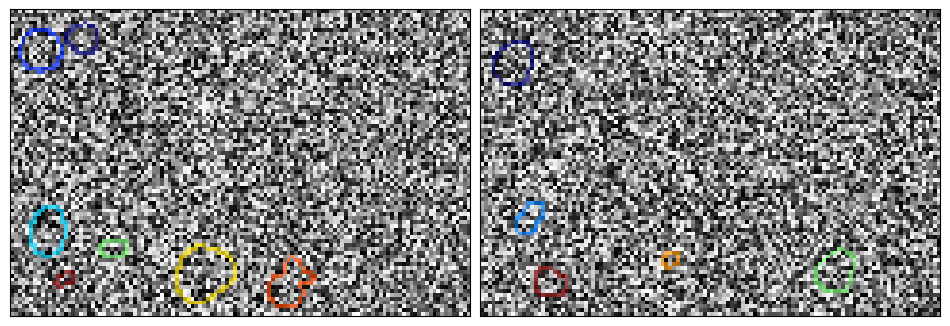

In [13]:
from matplotlib import pyplot as plt
from baby.visualise import plot_ims, colour_segstack
_, axs = plot_ims(img.squeeze(), show=False)
for ax, edgemasks in zip(axs, all_edgemasks):
    ax.imshow(colour_segstack(edgemasks))
plt.show()